#**SEIS-639 Brain Tumor Classification**
## VGG-16 v3

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
# Mounting my personal google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setting working directory
%cd drive/'My Drive'/

/content/drive/My Drive


In [4]:
# To see if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


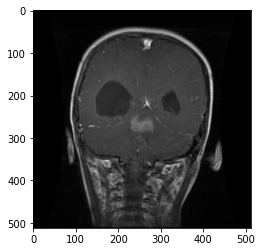

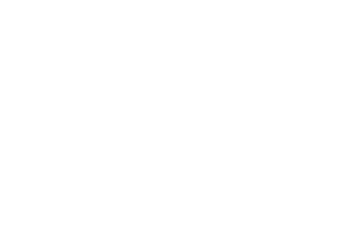

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

data_dir = "dataset/Training"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 223.5, 223.5, -0.5)

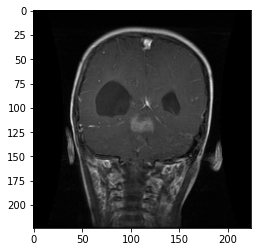

In [6]:
img_size = 224
new_array = cv2.resize(img_array,(img_size,img_size))    
plt.imshow(new_array,cmap = "gray"
           )
plt.axis("on")

In [7]:
new_array.shape

(224, 224, 3)

In [8]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(data_dir,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array,(img_size,img_size)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [9]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,img_size,img_size, 3)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,img_size,img_size,3)

(2870, 224, 224, 3)


In [10]:
 # convert to one-hot-encoding
from keras.utils.np_utils import to_categorical
y = to_categorical(y, num_classes = 4)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 224, 224, 3)
x_test shape (574, 224, 224, 3)
y_train shape (2296, 4)
y_test shape (574, 4)


In [12]:
epochs = 100
batch_size = 40

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False
                             )
datagen.fit(X_train)

train_data_gen = datagen.flow(X_train,
                              Y_train, 
                              batch_size=batch_size)

validation_data_gen = (X_val, Y_val)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.applications.vgg16 import VGG16

# Transfer Learning VGG-16
vgg_conv = VGG16(include_top = False, 
                 weights = 'imagenet', 
                 input_shape = (224, 224, 3)
                 )
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Fully connected layers
last = vgg_conv.output

x = Flatten()(last)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(256)(x) 
x = BatchNormalization()(x) 
x = Activation('relu')(x)
x = Dropout(0.25)(x)

my_pred = Dense(4, activation='softmax')(x)

# Combining VGG16 with my FC and softmax
from keras.models import Model
my_model = Model(vgg_conv.input, my_pred)
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
# Keep convolutional layers weights unchanged, but update FC layers.
i = 0

for layer in my_model.layers[:19]:
  layer.trainable = False
  i = i + 1
  print(i, layer.name)

1 input_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


In [16]:
import time
start = time.time()
my_model.compile(optimizer='adam', 
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=15)

# Fit model
fitted_model = my_model.fit(train_data_gen,
                         validation_data = validation_data_gen,
                         epochs=epochs,
                         steps_per_epoch = X_train.shape[0] // batch_size,
                         callbacks=[es],
                         verbose=1
                         )
finish = time.time()
print("training time: ", (finish-start))

Epoch 1/100
57/57 [==============================] - 70s 523ms/step - loss: 0.8644 - accuracy: 0.7026 - val_loss: 1.1573 - val_accuracy: 0.7091
Epoch 2/100
57/57 [==============================] - 12s 217ms/step - loss: 0.3199 - accuracy: 0.8901 - val_loss: 0.6454 - val_accuracy: 0.8136
Epoch 3/100
57/57 [==============================] - 13s 220ms/step - loss: 0.2093 - accuracy: 0.9206 - val_loss: 0.7361 - val_accuracy: 0.8171
Epoch 4/100
57/57 [==============================] - 13s 222ms/step - loss: 0.1894 - accuracy: 0.9304 - val_loss: 0.3846 - val_accuracy: 0.8920
Epoch 5/100
57/57 [==============================] - 13s 221ms/step - loss: 0.1095 - accuracy: 0.9598 - val_loss: 0.3548 - val_accuracy: 0.8798
Epoch 6/100
57/57 [==============================] - 12s 219ms/step - loss: 0.0951 - accuracy: 0.9683 - val_loss: 0.3943 - val_accuracy: 0.8833
Epoch 7/100
57/57 [==============================] - 12s 218ms/step - loss: 0.0784 - accuracy: 0.9710 - val_loss: 0.4177 - val_accuracy:

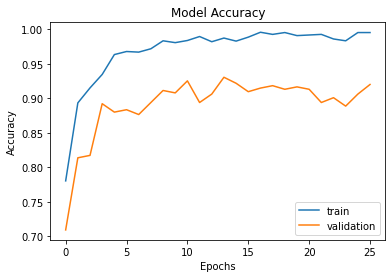

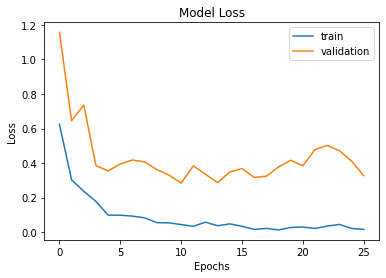

In [17]:
# History for accuracy
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# History for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [18]:
# Reports
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = my_model.predict(X_val)

# Labels are still one-hot encoded, for that reason we need to convert them to single-digit ones
y_pred = np.argmax(Y_pred, axis=1)
Y_val = np.argmax(Y_val, axis=1)


print('Confusion Matrix')
print(confusion_matrix(Y_val, y_pred))
print()
print('Classification Report')
report = classification_report(Y_val, y_pred, target_names=CATEGORIES)
print(report)

Confusion Matrix
[[168  11   0   0]
 [  7 154   4   4]
 [  1  10  57   2]
 [  0   6   1 149]]

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.94      0.95       179
meningioma_tumor       0.85      0.91      0.88       169
        no_tumor       0.92      0.81      0.86        70
 pituitary_tumor       0.96      0.96      0.96       156

        accuracy                           0.92       574
       macro avg       0.92      0.90      0.91       574
    weighted avg       0.92      0.92      0.92       574



Confusion matrix, without normalization


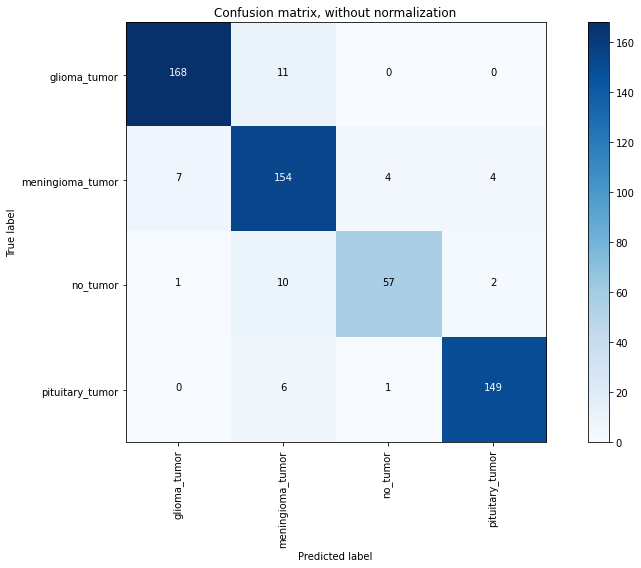

In [19]:
# Defining confusion matrix function to plot that can be normalized as well

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plotting my model
cnf_matrix = confusion_matrix(Y_val, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix, classes=CATEGORIES,
                      title='Confusion matrix, without normalization')
plt.tight_layout()

In [20]:
#my_model.save('model_v2_final')